# data preparation and baseline model

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.dummy import DummyClassifier
from sklearn.metrics import plot_confusion_matrix, confusion_matrix

In [2]:
X_train = pd.read_csv('data/Training_set_values.csv', index_col='id')
X_test = pd.read_csv('data/Test_set_values.csv', index_col='id')
y_train = pd.read_csv('data/Training_set_labels.csv', index_col='id')

In [3]:
X_train.head()

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
id,,,,,,,,,,,,,,,,,,,,,
69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [4]:
y_train.head()

,status_group
id,
69572,functional
8776,functional
34310,functional
67743,non functional
19728,functional


### merging the X and y train data

In [5]:
df = X_train.merge(y_train, on='id')

*  We merged the X train and y train data to build a dataframe that we could use to test our different models on. The dataset from where the data came did not have a y test dataset. We will split the merged dataset and create a hold out group later.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 69572 to 26348
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   amount_tsh             59400 non-null  float64
 1   date_recorded          59400 non-null  object 
 2   funder                 55765 non-null  object 
 3   gps_height             59400 non-null  int64  
 4   installer              55745 non-null  object 
 5   longitude              59400 non-null  float64
 6   latitude               59400 non-null  float64
 7   wpt_name               59400 non-null  object 
 8   num_private            59400 non-null  int64  
 9   basin                  59400 non-null  object 
 10  subvillage             59029 non-null  object 
 11  region                 59400 non-null  object 
 12  region_code            59400 non-null  int64  
 13  district_code          59400 non-null  int64  
 14  lga                    59400 non-null  object 
 15

**note:** our initial dataset included 40 features

### data exploration and cleaning

In [7]:
df.isna().sum()

amount_tsh                   0
date_recorded                0
funder                    3635
gps_height                   0
installer                 3655
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            3334
recorded_by                  0
scheme_management         3877
scheme_name              28166
permit                    3056
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_group                0
quantity

In [8]:
df.status_group.value_counts(normalize=True)

functional                 0.543081
non functional             0.384242
functional needs repair    0.072677
Name: status_group, dtype: float64

**note:** <br>
*  the target variable (status_group) is imbalanced. <br>
    -  approximately 54% 'functional', 38% 'non functional', and 7% 'functional needs repair'.

### dropping some features we determined we don't need based on what we've gathered from exploring the data

In [9]:
cols_to_drop = ['amount_tsh',
                'scheme_name', 
                'date_recorded', 
                'wpt_name', 
                'subvillage', 
                'lga', 
                'ward', 
                'recorded_by', 
                'quantity_group',
                'quality_group',
                'payment_type', 
                'funder', 
                'extraction_type_group', 
                'extraction_type_class',
                'management_group',
                'source_type',
                'source_class',
                'waterpoint_type_group'
]
df = df.drop(cols_to_drop, axis = 1)
df = df.fillna('missing', axis = 1)

**note:** 

*  with so many unique values for some features, onehotencoding creates more than 60,000 columns (out of a dataframe with 59,400 entries), making our models computationally prohibitive. <br> 

*  we examined each feature based on the descriptions provided on the competitions website (url provided below). <br>
    -  **competition website:** https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/25/#labels_list <br>

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 69572 to 26348
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gps_height         59400 non-null  int64  
 1   installer          59400 non-null  object 
 2   longitude          59400 non-null  float64
 3   latitude           59400 non-null  float64
 4   num_private        59400 non-null  int64  
 5   basin              59400 non-null  object 
 6   region             59400 non-null  object 
 7   region_code        59400 non-null  int64  
 8   district_code      59400 non-null  int64  
 9   population         59400 non-null  int64  
 10  public_meeting     59400 non-null  object 
 11  scheme_management  59400 non-null  object 
 12  permit             59400 non-null  object 
 13  construction_year  59400 non-null  int64  
 14  extraction_type    59400 non-null  object 
 15  management         59400 non-null  object 
 16  payment           

### we noticed that several features were duplicative so we decided to drop them from our dataset. below is a list of columns that were dropped and our reasoning for excluding them: <br>

|feature|description|reason|
|-------|-----------|------|
|amount_tsh|total static head (amount water available to waterpoint)|70% of the information in this column had a value of 0, not useful for modeling|
|scheme_name|who operates the waterpoint|did not provide much information regarding functionality|
|date_recorded|the date the row was entered|~95% of waterpoints were recorded between 2011-2013, not useful for modeling|
|wpt_name|name of the waterpoint if there is one|did not provide much information regarding functionality|
|subvillage|geographic location|duplicative, ~19K unique values, 'region' column captures a broader geographical range|
|lga|geographic location|dropped due to having several other location features which provided greater detail|
|ward|geographic location|dropped due to having several other location features which provided greater detail|
|recorded_by|group entering this row of data|column only has one value, not useful for modeling|
|quantity_group|the quantity of water|duplicative, 'quantity' has the exact same information|
|quality_group|the quality of the water|similar information as 'water_quality', however, 'water_quality' has more unique values which is more beneficical for modeling|
|payment_type|what the water costs|duplicative, column contains same exact information as 'payment'|
|funder|who funded the well|~2k unique values, decided to drop to improve the speed of our models|
|extraction_type_group|the kind of extraction the waterpoint uses|similar information to 'extraction_type', however, 'extraction_type' has greater unique values which is more beneficial for modeling|
|extraction_type_class|the kind of extraction the waterpoint uses|similar information to 'extraction_type', however, 'extraction_type' has greater unique values which is more beneficial for modeling|
|management_group|how the waterpoint is managed|contained similar information to 'management', however, 'management' provided greater detail which is more beneficial for modeling|
|source_type|the source of the water|contained similar information to 'source', however, 'source' provided more detail|
|source_class|the source of the water|contained similar information to 'source', however, 'source' provided more detail|
|waterpoint_type_group|the kind of waterpoint|similar information as 'waterpoint_type', however, 'waterpoint_type' provided more detail|

##### we also replaced NaN values with 'missing' to keep the rows in our dataframe. we will onehotencode the dataframe later

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 69572 to 26348
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gps_height         59400 non-null  int64  
 1   installer          59400 non-null  object 
 2   longitude          59400 non-null  float64
 3   latitude           59400 non-null  float64
 4   num_private        59400 non-null  int64  
 5   basin              59400 non-null  object 
 6   region             59400 non-null  object 
 7   region_code        59400 non-null  int64  
 8   district_code      59400 non-null  int64  
 9   population         59400 non-null  int64  
 10  public_meeting     59400 non-null  object 
 11  scheme_management  59400 non-null  object 
 12  permit             59400 non-null  object 
 13  construction_year  59400 non-null  int64  
 14  extraction_type    59400 non-null  object 
 15  management         59400 non-null  object 
 16  payment           

**note:**

*  our dataset is now left with 22 features.

we will clean of the installer column by replacing 0 values with 'missing' to match our previous imputation, changing certain records that obviously belong with others (e.g. 'Commu' with 'Community), and then binning the top twenty installers and labeling the rest as 'other'.  We do this to reduce the number of unique values in the column from 2146 to around twenty.  

In [12]:
df['installer'].replace(to_replace='0', value='missing', inplace=True)
df['installer'].replace('Gover', 'Government', inplace=True)
df['installer'].replace('Commu', 'Community')
df['installer'].replace('District council', 'District Council', inplace=True)

toptwenty_installers = list(df.installer.value_counts()[:21].index)
toptwenty_installers.remove('missing')
df.installer = df.installer.apply(lambda x: x if x in toptwenty_installers else 'other')

### creating a holdout set and running a train_test_split

*  the holdout set will be used for additional testing of our final model.

In [13]:
df, holdout = train_test_split(df, test_size = .1, random_state=42)

In [14]:
X = df.drop('status_group', axis=1)
y = df['status_group']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

we comment out the cells below so as not to overwrite the files each time the notebook is run. 

In [15]:
#X_train.to_csv('data/X_train.csv')
#X_test.to_csv('data/X_test.csv')
#y_train.to_csv('data/y_train.csv')
#y_test.to_csv('data/y_test.csv')
#df.to_csv('data/holdout_data.csv')

# baseline dummy model

we create a baseline dummy model using DummyClassifier, which should predict that all wells are functional (when using the 'most_frequent' strategy).

In [16]:
dummy_model = DummyClassifier(strategy='most_frequent', random_state=42)
dummy_model.fit(X_train, y_train)

DummyClassifier(random_state=42, strategy='most_frequent')

In [17]:
print('Accuracy Score Train:', dummy_model.score(X_train, y_train))
print('Accuracy Score Test:', dummy_model.score(X_test, y_test))

Accuracy Score Train: 0.5436089287941139
Accuracy Score Test: 0.543658810325477


In [18]:
log_loss_dummy = cross_val_score(dummy_model, X_train, y_train, scoring='neg_log_loss')
log_loss_dummy = -log_loss_dummy.mean()
print('Log Loss:', log_loss_dummy)

Log Loss: 15.763189157013858


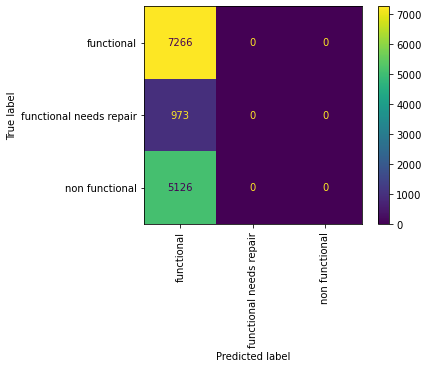

In [19]:
plot_confusion_matrix(dummy_model, X_test, y_test, xticks_rotation='vertical');

In [20]:
y_pred = dummy_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
func = cm[0][0] / (cm[0][0] + cm[0][1] + cm[0][2])
func_nr = cm[1][1] / (cm[1][0] + cm[1][1] + cm[1][2])
non_func = cm[2][2] / (cm[2][0] + cm[2][1] + cm[2][2])
print(f'The model correctly predicts {round(func*100, 2)}% of the funtional wells.')
print(f'The model correctly predicts {round(func_nr*100, 2)}% of the funtional-needs-repair wells.')
print(f'The model correctly predicts {round(non_func*100, 2)}% of the non-functional wells.')

The model correctly predicts 100.0% of the funtional wells.
The model correctly predicts 0.0% of the funtional-needs-repair wells.
The model correctly predicts 0.0% of the non-functional wells.


**note:**

*  as expected, the dummy model predicts 'functional' all the time.  this produces an overall accuracy score on the test data of 54.4%. 